In [0]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time 

import pandas as pd

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available. Training on CPU ...

# Import Data

References: <br>
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html <br>
https://datahacker.rs/009-pytorch-building-an-artificial-neural-network-with-perceprton-on-cifar10-using-pytorch/ <br>
https://datahacker.rs/005-pytorch-convolutional-neural-network-on-mnist-in-pytorch/ <br>
https://www.kaggle.com/shadabhussain/cifar-10-cnn-using-pytorch/notebook

In [0]:
#load data and convert to tensors
path = '../data_cifar/'
train_set = CIFAR10(path, train=True, download=True, transform=transforms.ToTensor())
test_set = CIFAR10(path, train=False, download=True, transform=transforms.ToTensor())

print ("Train size: {}, Test size: {}".format(len(train_set), len(test_set)))



Files already downloaded and verified
Files already downloaded and verified
Train size: 50000, Test size: 10000

torch.Size([3, 32, 32]) 6
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bird
Out[399]:

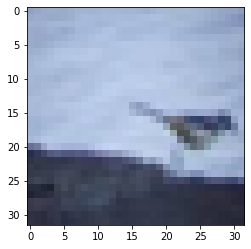

<matplotlib.image.AxesImage at 0x7f6909f11a60>

In [0]:
#inspect data 
print(train_set[0][0].shape, train_set[0][1])

print(train_set.classes)

data, label = train_set[-5]
print(train_set.classes[label])

plt.imshow(data.permute((1, 2, 0))) #reshapes 3 x 32 x 32 to 32 x 32 x 3

### Define constants

In [0]:
INPUT_SIZE = 32*32*3
NUM_CLASSES = 10
SEED = 97
TRAIN_BATCH_SIZE = 100  
TEST_BATCH_SIZE = 500
VAL_SET_SIZE = 5000

torch.manual_seed(SEED)


Out[400]: <torch._C.Generator at 0x7f6964299630>

In [0]:
v = VAL_SET_SIZE
t = (len(train_set)-VAL_SET_SIZE)
print(t, " ",  v)

45000 5000

In [0]:
#create validation set 
train_set, val_set = random_split(train_set, [(len(train_set)-VAL_SET_SIZE), VAL_SET_SIZE] )
print(f'Train set: {len(train_set)}, Validation set: {len(val_set)}')

Train set: 45000, Validation set: 5000

In [0]:
#set up data loader to load in batches
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size = TEST_BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False)

# Helper Functions

In [0]:
def train_NN(model, num_epochs, optimizer_fxn, loss_fxn, isCNN = False):
  
  time_start = time.time()
  
  train_metrics = pd.DataFrame(columns = ['epoch', 't_loss', 't_accuracy', 'v_loss', 'v_accuracy'])
  
  #for each epoch
  for i in range(0, num_epochs):
    
    correct_pred_train = 0 #for epoch 
    correct_pred_val = 0 #for epoch
    
    #for each batch 
    batch_num = 1 
    for X_train, y_train in train_loader:
      
      #forward pass 
      if isCNN:
        y_out = model(X_train)
      else:
        y_out = model(X_train.view(TRAIN_BATCH_SIZE, -1)) #flattens data
        
      #calculate loss
      loss = loss_fxn(y_out, y_train)
      #calculate predicted class
      y_pred = torch.max(y_out.data, 1)[1]
      #calculate number of correct predictions 
      correct_pred = (y_pred == y_train).sum() #for batch 
      correct_pred_train += correct_pred 
      
      #backward pass 
      optimizer_fxn.zero_grad() #resetgradients to 0 
      loss.backward()
      #calculate gradients 
      optimizer_fxn.step()
       
      if batch_num%100 == 0:
        #print("correct pred: {}, batch num : {}".format(correct_pred_train, batch_num))
        print("epoch {} batch {}------loss: {} accuracy: {} %".format(i, batch_num, loss, round((correct_pred_train.item()/(TRAIN_BATCH_SIZE*batch_num))*100, 3) ))
        
      batch_num += 1
      
    
    accuracy = (correct_pred_train.item()/(TRAIN_BATCH_SIZE*batch_num))*100 
    
    
    #check performance against validation set
    with torch.no_grad():
      
      for X_val, y_val in val_loader:
        #forward pass 
        if isCNN:
          y_out = model(X_val)
        else:
          y_out = model(X_val.view(TEST_BATCH_SIZE, -1)) #flattens data
          
        #get predicted class   
        y_pred = torch.max(y_out.data, 1)[1]
        correct_pred_val += (y_pred == y_val).sum()
        
    #calculate validation accuracy + loss    
    loss_val = loss_fxn(y_out, y_val)
    v_accuracy = (correct_pred_val.item()/VAL_SET_SIZE)*100
    
    #save result
    new_result = {'epoch': i+1, 't_loss': loss.item(), 't_accuracy': accuracy, 'v_loss': loss_val.item(), 'v_accuracy': v_accuracy } 
    train_metrics = train_metrics.append(new_result, ignore_index = True)
  
  time_elapsed = time.time() - time_start
  print("total time elapsed: {} s".format(round(time_elapsed,2)))
  
  return model, train_metrics, time_elapsed 


def test_NN(model, loss_fxn, isCNN = False):
  
  time_start = time.time()
  correct_pred_test = 0 
  all_pred = torch.Tensor()
  y_actual = torch.Tensor()
  
  with torch.no_grad():
    
    batch_num = 1
    for X_test, y_test in test_loader:
      #forward pass 
      if isCNN:
        y_out = model(X_test)
      else:
        y_out = model(X_test.view(TEST_BATCH_SIZE, -1)) #flattens image
      #print(X_test.view(TEST_BATCH_SIZE, -1).shape)
      #get predicted class   
      y_pred = torch.max(y_out.data, 1)[1]
      y_actual = torch.cat((y_actual, y_test), 0) 
      all_pred = torch.cat((all_pred, y_pred), 0) 
      #calculate loss 
      loss = loss_fxn(y_out, y_test)
      #calculate number of correct predictions 
      correct_pred = (y_pred == y_test).sum() #for batch 
      correct_pred_test += correct_pred 
      
      batch_num += batch_num 
         
  time_elapsed = round(time.time() - time_start, 2) 
  accuracy = round((correct_pred_test.item()/len(test_set))*100, 2)
  
  print(f'Test set: \nTime elapsed: {time_elapsed} s Accuracy: {accuracy} ') #loss: {loss}
    
  return time_elapsed, loss, accuracy, all_pred, y_actual

def plot_confusion_matrix(cm):
  fig = plt.figure(figsize=(16,5))   
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(test_set.classes);
  ax.yaxis.set_ticklabels(test_set.classes);
  ax.tick_params(axis='y', rotation=30)

def plot_accuracy_loss(train_metrics):
  fig = plt.figure(figsize=(16,5))                                  
  ax1 = fig.add_subplot(121)
  sns.lineplot(data=train_metrics, x="epoch", y="t_loss")
  sns.lineplot(data=train_metrics, x="epoch", y="v_loss")
  plt.legend(['Training set', 'Validation set'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  ax1.set_title('Training set: Loss')
  ax2 = fig.add_subplot(122)
  sns.lineplot(data=train_metrics, x="epoch", y="t_accuracy")
  sns.lineplot(data=train_metrics, x="epoch", y="v_accuracy")
  plt.legend(['Training set', 'Validation set'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy % ')
  ax2.set_title('Training set: Accuracy')
  None

# Neural Network

In [0]:
#Define network architecture
class FCNeuralNetwork(nn.Module):

    def __init__(self, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1024) #  input layer 
        self.fc2 = nn.Linear(1024, 512) #size = 1024
        self.fc3 = nn.Linear(512, 256) #size = 512
        self.fc4 = nn.Linear(256, 64) #size = 256
        self.fc5 = nn.Linear(64, output_size) #size = 64

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X)) #self.fc5(X)
        return X #F.log_softmax(X, dim=1) 
      

## Optimizers

### SGD

#### lr = 0.05

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 15, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.294995069503784 accuracy: 11.83 %
epoch 0 batch 200------loss: 2.249373435974121 accuracy: 14.835 %
epoch 0 batch 300------loss: 2.179997444152832 accuracy: 15.96 %
epoch 0 batch 400------loss: 2.1453797817230225 accuracy: 16.965 %
epoch 1 batch 100------loss: 2.1166646480560303 accuracy: 23.85 %
epoch 1 batch 200------loss: 2.0225377082824707 accuracy: 24.41 %
epoch 1 batch 300------loss: 1.9513237476348877 accuracy: 25.12 %
epoch 1 batch 400------loss: 2.1223087310791016 accuracy: 25.96 %
epoch 2 batch 100------loss: 1.912632703781128 accuracy: 30.4 %
epoch 2 batch 200------loss: 1.914696216583252 accuracy: 30.055 %
epoch 2 batch 300------loss: 1.9405932426452637 accuracy: 30.773 %
epoch 2 batch 400------loss: 1.7741352319717407 accuracy: 31.225 %
epoch 3 batch 100------loss: 1.7673109769821167 accuracy: 34.62 %
epoch 3 batch 200------loss: 1.7947925329208374 accuracy: 34.305 %
epoch 3 batch 300------loss: 1.8643499612808228 accuracy: 34.723 %
epoch 3 batch 400------loss: 1.9154541492462158 accuracy: 34.958 %
epoch 4 batch 100------loss: 1.7541462182998657 accuracy: 37.35 %
epoch 4 batch 200------loss: 1.7555944919586182 accuracy: 37.41 %
epoch 4 batch 300------loss: 1.8503891229629517 accuracy: 37.27 %
epoch 4 batch 400------loss: 1.7650834321975708 accuracy: 37.638 %
epoch 5 batch 100------loss: 1.6995090246200562 accuracy: 39.14 %
epoch 5 batch 200------loss: 1.6181010007858276 accuracy: 39.58 %
epoch 5 batch 300------loss: 1.6340835094451904 accuracy: 39.533 %
epoch 5 batch 400------loss: 1.723052978515625 accuracy: 39.675 %
epoch 6 batch 100------loss: 1.5984399318695068 accuracy: 40.99 %
epoch 6 batch 200------loss: 1.5610426664352417 accuracy: 41.165 %
epoch 6 batch 300------loss: 1.7510513067245483 accuracy: 41.457 %
epoch 6 batch 400------loss: 1.4754877090454102 accuracy: 41.645 %
epoch 7 batch 100------loss: 1.5485429763793945 accuracy: 42.93 %
epoch 7 batch 200------loss: 1.5746772289276123 accuracy: 42.82 %
epoch 7 batch 300------loss: 1.5581523180007935 accuracy: 43.07 %
epoch 7 batch 400------loss: 1.6249924898147583 accuracy: 43.053 %
epoch 8 batch 100------loss: 1.521012544631958 accuracy: 44.64 %
epoch 8 batch 200------loss: 1.4381321668624878 accuracy: 44.05 %
epoch 8 batch 300------loss: 1.6321954727172852 accuracy: 44.117 %
epoch 8 batch 400------loss: 1.526606798171997 accuracy: 44.112 %
epoch 9 batch 100------loss: 1.599297046661377 accuracy: 45.3 %
epoch 9 batch 200------loss: 1.4188159704208374 accuracy: 45.865 %
epoch 9 batch 300------loss: 1.5054640769958496 accuracy: 45.723 %
epoch 9 batch 400------loss: 1.5995876789093018 accuracy: 45.557 %
epoch 10 batch 100------loss: 1.4235949516296387 accuracy: 46.44 %
epoch 10 batch 200------loss: 1.3636938333511353 accuracy: 46.175 %
epoch 10 batch 300------loss: 1.5527527332305908 accuracy: 46.51 %
epoch 10 batch 400------loss: 1.6199843883514404 accuracy: 46.6 %
epoch 11 batch 100------loss: 1.7689155340194702 accuracy: 47.55 %
epoch 11 batch 200------loss: 1.3637653589248657 accuracy: 47.64 %
epoch 11 batch 300------loss: 1.354447841644287 accuracy: 47.893 %
epoch 11 batch 400------loss: 1.6351289749145508 accuracy: 47.892 %
epoch 12 batch 100------loss: 1.3555248975753784 accuracy: 49.39 %
epoch 12 batch 200------loss: 1.5895832777023315 accuracy: 49.22 %
epoch 12 batch 300------loss: 1.2998955249786377 accuracy: 48.977 %
epoch 12 batch 400------loss: 1.4104056358337402 accuracy: 49.05 %
epoch 13 batch 100------loss: 1.5440667867660522 accuracy: 49.5 %
epoch 13 batch 200------loss: 1.4095392227172852 accuracy: 49.64 %
epoch 13 batch 300------loss: 1.5198030471801758 accuracy: 49.95 %
epoch 13 batch 400------loss: 1.3853205442428589 accuracy: 49.915 %
epoch 14 batch 100------loss: 1.192357063293457 accuracy: 51.38 %
epoch 14 batch 200------loss: 1.4704174995422363 accuracy: 51.38 %
epoch 14 batch 300------loss: 1.513261079788208 accuracy: 51.03 %
epoch 14 batch 400------loss: 1.379703402519226 accuracy: 51.023 %
total time 

Time elapsed for training: 2.531 min, Accuracy: 50.99 %

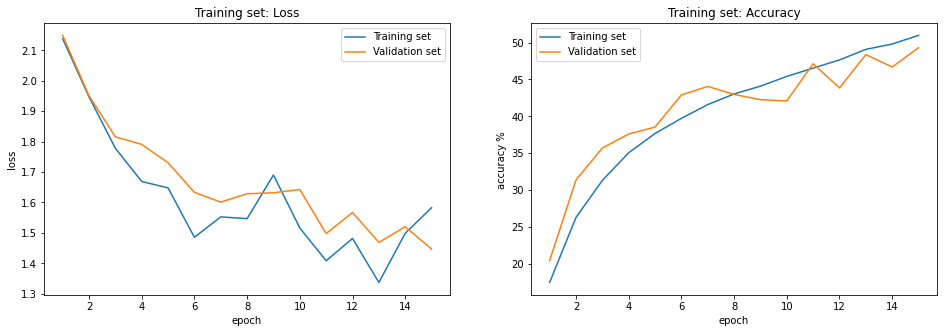

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.21 s Accuracy: 49.46

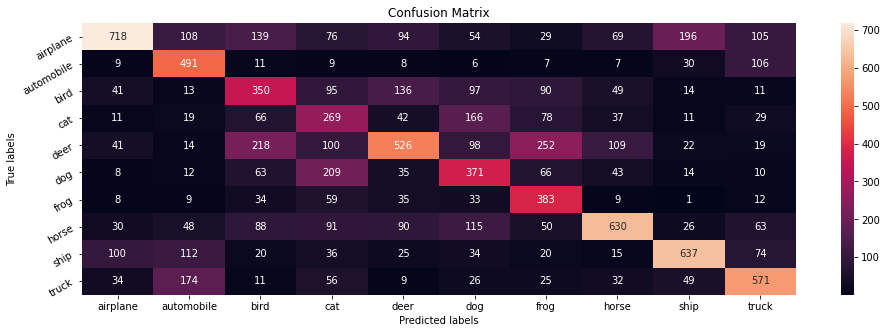

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

#### lr = 0.1

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 15, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.2825567722320557 accuracy: 13.6 %
epoch 0 batch 200------loss: 2.463477849960327 accuracy: 14.71 %
epoch 0 batch 300------loss: 2.1241297721862793 accuracy: 16.043 %
epoch 0 batch 400------loss: 2.1468682289123535 accuracy: 16.955 %
epoch 1 batch 100------loss: 2.1099960803985596 accuracy: 22.42 %
epoch 1 batch 200------loss: 2.1754486560821533 accuracy: 23.205 %
epoch 1 batch 300------loss: 2.038097858428955 accuracy: 24.257 %
epoch 1 batch 400------loss: 2.018887758255005 accuracy: 24.953 %
epoch 2 batch 100------loss: 2.0716187953948975 accuracy: 29.7 %
epoch 2 batch 200------loss: 1.9789130687713623 accuracy: 29.48 %
epoch 2 batch 300------loss: 1.9754329919815063 accuracy: 30.113 %
epoch 2 batch 400------loss: 1.936025857925415 accuracy: 30.645 %
epoch 3 batch 100------loss: 1.7110662460327148 accuracy: 33.79 %
epoch 3 batch 200------loss: 1.7120819091796875 accuracy: 34.165 %
epoch 3 batch 300------loss: 1.7451969385147095 accuracy: 34.447 %
epoch 3 batch 400------loss: 1.8669177293777466 accuracy: 34.627 %
epoch 4 batch 100------loss: 1.8822299242019653 accuracy: 37.44 %
epoch 4 batch 200------loss: 1.7060234546661377 accuracy: 37.375 %
epoch 4 batch 300------loss: 1.7809274196624756 accuracy: 37.2 %
epoch 4 batch 400------loss: 1.7791272401809692 accuracy: 37.433 %
epoch 5 batch 100------loss: 1.790212869644165 accuracy: 38.87 %
epoch 5 batch 200------loss: 1.8678507804870605 accuracy: 38.785 %
epoch 5 batch 300------loss: 1.7682287693023682 accuracy: 38.96 %
epoch 5 batch 400------loss: 1.6919670104980469 accuracy: 39.115 %
epoch 6 batch 100------loss: 1.7908624410629272 accuracy: 39.92 %
epoch 6 batch 200------loss: 1.6179484128952026 accuracy: 40.12 %
epoch 6 batch 300------loss: 1.5838172435760498 accuracy: 40.76 %
epoch 6 batch 400------loss: 1.5388661623001099 accuracy: 41.125 %
epoch 7 batch 100------loss: 1.54714035987854 accuracy: 42.81 %
epoch 7 batch 200------loss: 1.4546397924423218 accuracy: 43.42 %
epoch 7 batch 300------loss: 1.629794716835022 accuracy: 43.53 %
epoch 7 batch 400------loss: 1.46931791305542 accuracy: 43.727 %
epoch 8 batch 100------loss: 1.7219369411468506 accuracy: 44.92 %
epoch 8 batch 200------loss: 1.6145113706588745 accuracy: 45.245 %
epoch 8 batch 300------loss: 1.2921745777130127 accuracy: 45.467 %
epoch 8 batch 400------loss: 1.476880669593811 accuracy: 45.797 %
epoch 9 batch 100------loss: 1.4811904430389404 accuracy: 46.66 %
epoch 9 batch 200------loss: 1.3678549528121948 accuracy: 46.49 %
epoch 9 batch 300------loss: 1.4353888034820557 accuracy: 46.837 %
epoch 9 batch 400------loss: 1.5667964220046997 accuracy: 46.935 %
epoch 10 batch 100------loss: 1.5578675270080566 accuracy: 48.7 %
epoch 10 batch 200------loss: 1.581589698791504 accuracy: 48.605 %
epoch 10 batch 300------loss: 1.4461424350738525 accuracy: 48.29 %
epoch 10 batch 400------loss: 1.49639093875885 accuracy: 48.29 %
epoch 11 batch 100------loss: 1.4316818714141846 accuracy: 49.98 %
epoch 11 batch 200------loss: 1.48699152469635 accuracy: 49.55 %
epoch 11 batch 300------loss: 1.5646251440048218 accuracy: 49.697 %
epoch 11 batch 400------loss: 1.3045119047164917 accuracy: 49.593 %
epoch 12 batch 100------loss: 1.275639533996582 accuracy: 49.42 %
epoch 12 batch 200------loss: 1.4728258848190308 accuracy: 50.275 %
epoch 12 batch 300------loss: 1.348929762840271 accuracy: 50.547 %
epoch 12 batch 400------loss: 1.370554804801941 accuracy: 50.423 %
epoch 13 batch 100------loss: 1.4748278856277466 accuracy: 51.65 %
epoch 13 batch 200------loss: 1.2944166660308838 accuracy: 51.93 %
epoch 13 batch 300------loss: 1.2128854990005493 accuracy: 51.567 %
epoch 13 batch 400------loss: 1.242875099182129 accuracy: 51.763 %
epoch 14 batch 100------loss: 1.1141464710235596 accuracy: 51.58 %
epoch 14 batch 200------loss: 1.4083787202835083 accuracy: 51.81 %
epoch 14 batch 300------loss: 1.594202995300293 accuracy: 52.01 %
epoch 14 batch 400------loss: 1.1383800506591797 accuracy: 52.28 %
total time elaps

Time elapsed for training: 2.467 min, Accuracy: 52.09 %

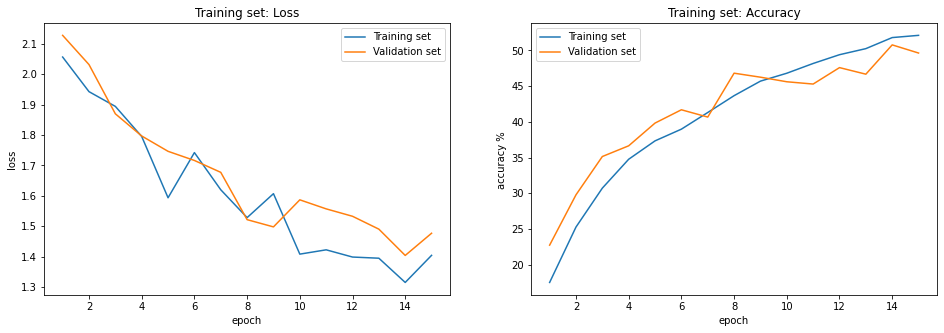

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.18 s Accuracy: 48.98

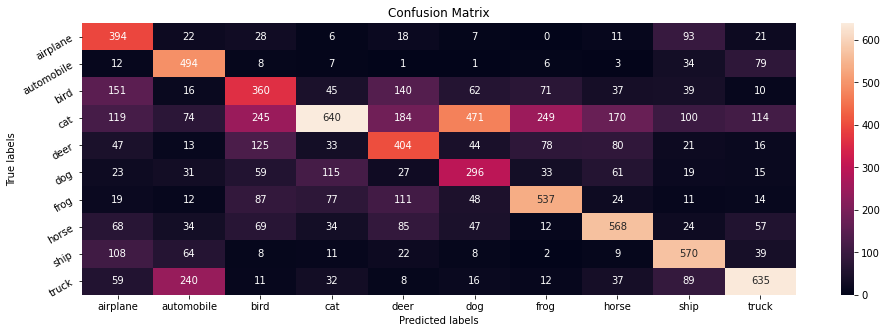

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### Adam

#### lr = 0.001

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr = 0.001 )

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 8, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.227673292160034 accuracy: 15.33 %
epoch 0 batch 200------loss: 2.2293851375579834 accuracy: 17.92 %
epoch 0 batch 300------loss: 2.166243314743042 accuracy: 18.993 %
epoch 0 batch 400------loss: 2.1114253997802734 accuracy: 20.21 %
epoch 1 batch 100------loss: 2.1826982498168945 accuracy: 27.98 %
epoch 1 batch 200------loss: 1.985886812210083 accuracy: 28.515 %
epoch 1 batch 300------loss: 1.9433376789093018 accuracy: 28.727 %
epoch 1 batch 400------loss: 2.0317986011505127 accuracy: 28.983 %
epoch 2 batch 100------loss: 2.059434652328491 accuracy: 31.15 %
epoch 2 batch 200------loss: 1.8429217338562012 accuracy: 31.42 %
epoch 2 batch 300------loss: 1.961243748664856 accuracy: 31.883 %
epoch 2 batch 400------loss: 1.851477026939392 accuracy: 31.877 %
epoch 3 batch 100------loss: 1.9346143007278442 accuracy: 33.43 %
epoch 3 batch 200------loss: 2.069525957107544 accuracy: 33.89 %
epoch 3 batch 300------loss: 1.8752528429031372 accuracy: 33.927 %
epoch 3 batch 400------loss: 1.9870550632476807 accuracy: 33.875 %
epoch 4 batch 100------loss: 1.959221601486206 accuracy: 34.62 %
epoch 4 batch 200------loss: 1.883103847503662 accuracy: 35.805 %
epoch 4 batch 300------loss: 1.7125581502914429 accuracy: 36.52 %
epoch 4 batch 400------loss: 1.6717056035995483 accuracy: 36.938 %
epoch 5 batch 100------loss: 1.8096541166305542 accuracy: 38.46 %
epoch 5 batch 200------loss: 1.7618027925491333 accuracy: 39.38 %
epoch 5 batch 300------loss: 1.6129603385925293 accuracy: 39.747 %
epoch 5 batch 400------loss: 1.852668046951294 accuracy: 39.3 %
epoch 6 batch 100------loss: 1.667047142982483 accuracy: 39.87 %
epoch 6 batch 200------loss: 1.8248745203018188 accuracy: 40.265 %
epoch 6 batch 300------loss: 1.8501337766647339 accuracy: 40.543 %
epoch 6 batch 400------loss: 1.7360423803329468 accuracy: 40.637 %
epoch 7 batch 100------loss: 1.5844240188598633 accuracy: 42.64 %
epoch 7 batch 200------loss: 1.853957176208496 accuracy: 42.0 %
epoch 7 batch 300------loss: 1.5427325963974 accuracy: 41.837 %
epoch 7 batch 400------loss: 1.696466326713562 accuracy: 42.075 %
total time elapsed: 140.34 s

Time elapsed for training: 2.339 min, Accuracy: 41.95 %

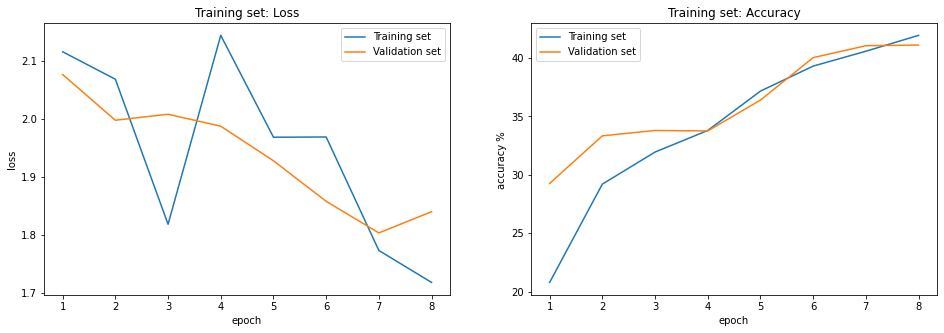

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)


Test set: 
Time elapsed: 1.84 s Accuracy: 40.26

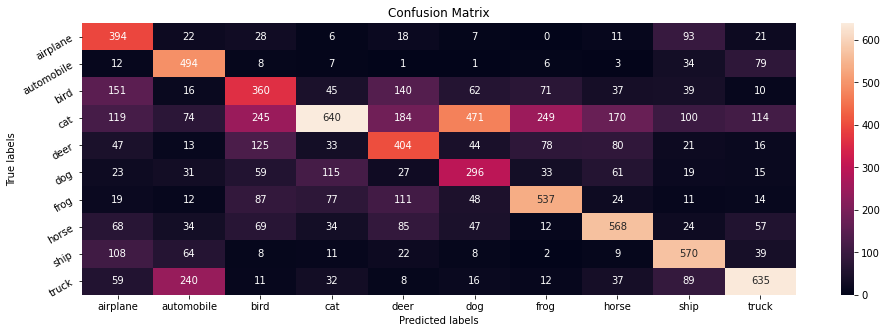

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

plot_confusion_matrix(cm)


#### lr = 0.0005

In [0]:
model = FCNeuralNetwork()
loss = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr = 0.0005 )

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 8, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.136220693588257 accuracy: 14.94 %
epoch 0 batch 200------loss: 2.1913416385650635 accuracy: 17.265 %
epoch 0 batch 300------loss: 2.1481215953826904 accuracy: 18.86 %
epoch 0 batch 400------loss: 2.155869722366333 accuracy: 20.433 %
epoch 1 batch 100------loss: 2.298980951309204 accuracy: 26.02 %
epoch 1 batch 200------loss: 2.130058526992798 accuracy: 26.16 %
epoch 1 batch 300------loss: 2.2825746536254883 accuracy: 26.663 %
epoch 1 batch 400------loss: 2.0880706310272217 accuracy: 26.643 %
epoch 2 batch 100------loss: 2.180050849914551 accuracy: 29.13 %
epoch 2 batch 200------loss: 1.9645124673843384 accuracy: 30.295 %
epoch 2 batch 300------loss: 1.9551074504852295 accuracy: 31.047 %
epoch 2 batch 400------loss: 1.920168161392212 accuracy: 31.64 %
epoch 3 batch 100------loss: 1.940420389175415 accuracy: 35.08 %
epoch 3 batch 200------loss: 1.912177324295044 accuracy: 35.22 %
epoch 3 batch 300------loss: 1.9675302505493164 accuracy: 34.97 %
epoch 3 batch 400------loss: 1.81978440284729 accuracy: 35.113 %
epoch 4 batch 100------loss: 1.8387030363082886 accuracy: 37.55 %
epoch 4 batch 200------loss: 1.8254257440567017 accuracy: 38.115 %
epoch 4 batch 300------loss: 1.8490580320358276 accuracy: 38.083 %
epoch 4 batch 400------loss: 1.8724877834320068 accuracy: 38.68 %
epoch 5 batch 100------loss: 1.6397788524627686 accuracy: 41.45 %
epoch 5 batch 200------loss: 1.7216792106628418 accuracy: 41.61 %
epoch 5 batch 300------loss: 1.760903000831604 accuracy: 42.267 %
epoch 5 batch 400------loss: 1.94993257522583 accuracy: 42.51 %
epoch 6 batch 100------loss: 1.6467441320419312 accuracy: 43.76 %
epoch 6 batch 200------loss: 1.741553544998169 accuracy: 43.72 %
epoch 6 batch 300------loss: 1.6759392023086548 accuracy: 43.873 %
epoch 6 batch 400------loss: 1.6647988557815552 accuracy: 44.12 %
epoch 7 batch 100------loss: 1.7049082517623901 accuracy: 44.77 %
epoch 7 batch 200------loss: 1.6416226625442505 accuracy: 44.84 %
epoch 7 batch 300------loss: 1.6850996017456055 accuracy: 44.887 %
epoch 7 batch 400------loss: 1.5943771600723267 accuracy: 45.08 %
total time elapsed: 137.48 s

Time elapsed for training: 2.291 min, Accuracy: 45.11 %

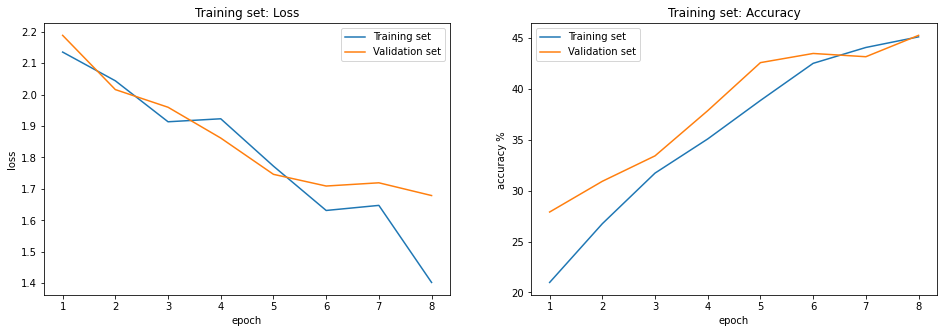

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )

plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.18 s Accuracy: 44.91

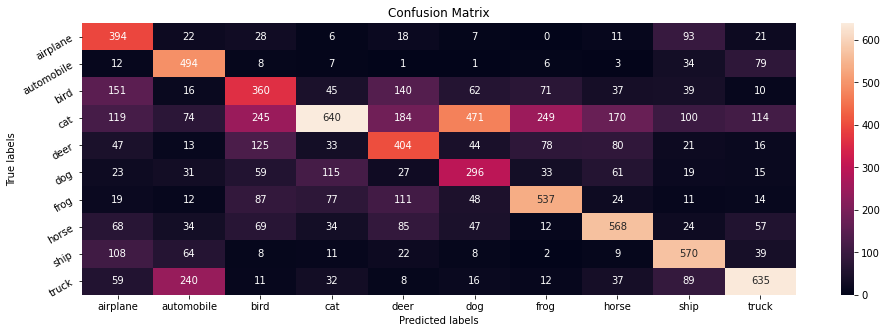

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)

plot_confusion_matrix(cm)


# add dropout

In [0]:
#Define network architecture
class NeuralNetwork(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.linear_layers = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.linear_layers(X)
        #calculate probabiliy distributions
        return  X #F.log_softmax(X, dim=1)

## P = 0.1

In [0]:
model = NeuralNetwork(dropout=0.1)
#print(model)
#for name,param in model.named_parameters():
#  print(name, ":", param.numel())

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.057912826538086 accuracy: 18.51 %
epoch 0 batch 200------loss: 1.9391953945159912 accuracy: 22.68 %
epoch 0 batch 300------loss: 1.8668828010559082 accuracy: 24.883 %
epoch 0 batch 400------loss: 1.8627104759216309 accuracy: 26.495 %
epoch 1 batch 100------loss: 1.9201127290725708 accuracy: 32.63 %
epoch 1 batch 200------loss: 1.7169160842895508 accuracy: 33.23 %
epoch 1 batch 300------loss: 1.7351516485214233 accuracy: 33.823 %
epoch 1 batch 400------loss: 1.827458143234253 accuracy: 34.337 %
epoch 2 batch 100------loss: 1.8237370252609253 accuracy: 35.78 %
epoch 2 batch 200------loss: 1.6550817489624023 accuracy: 36.305 %
epoch 2 batch 300------loss: 1.9314593076705933 accuracy: 36.833 %
epoch 2 batch 400------loss: 1.7998836040496826 accuracy: 37.108 %
epoch 3 batch 100------loss: 1.6807104349136353 accuracy: 38.71 %
epoch 3 batch 200------loss: 1.5634440183639526 accuracy: 39.0 %
epoch 3 batch 300------loss: 1.6750800609588623 accuracy: 39.037 %
epoch 3 batch 400------loss: 1.6920826435089111 accuracy: 39.352 %
epoch 4 batch 100------loss: 1.7550140619277954 accuracy: 40.81 %
epoch 4 batch 200------loss: 1.6615198850631714 accuracy: 41.2 %
epoch 4 batch 300------loss: 1.6757986545562744 accuracy: 41.167 %
epoch 4 batch 400------loss: 1.6196383237838745 accuracy: 41.215 %
epoch 5 batch 100------loss: 1.5306822061538696 accuracy: 42.39 %
epoch 5 batch 200------loss: 1.6861249208450317 accuracy: 42.515 %
epoch 5 batch 300------loss: 1.5452581644058228 accuracy: 42.76 %
epoch 5 batch 400------loss: 1.6646121740341187 accuracy: 42.782 %
epoch 6 batch 100------loss: 1.6201355457305908 accuracy: 43.87 %
epoch 6 batch 200------loss: 1.7857661247253418 accuracy: 43.98 %
epoch 6 batch 300------loss: 1.5154675245285034 accuracy: 43.957 %
epoch 6 batch 400------loss: 1.5417629480361938 accuracy: 44.01 %
epoch 7 batch 100------loss: 1.6790719032287598 accuracy: 44.86 %
epoch 7 batch 200------loss: 1.494536280632019 accuracy: 44.82 %
epoch 7 batch 300------loss: 1.6472684144973755 accuracy: 44.78 %
epoch 7 batch 400------loss: 1.6088906526565552 accuracy: 44.517 %
epoch 8 batch 100------loss: 1.4821988344192505 accuracy: 46.43 %
epoch 8 batch 200------loss: 1.5758401155471802 accuracy: 46.39 %
epoch 8 batch 300------loss: 1.556636929512024 accuracy: 46.02 %
epoch 8 batch 400------loss: 1.5620585680007935 accuracy: 45.815 %
epoch 9 batch 100------loss: 1.4648476839065552 accuracy: 46.37 %
epoch 9 batch 200------loss: 1.4174554347991943 accuracy: 46.84 %
epoch 9 batch 300------loss: 1.4388880729675293 accuracy: 46.7 %
epoch 9 batch 400------loss: 1.4149413108825684 accuracy: 46.685 %
epoch 10 batch 100------loss: 1.5901380777359009 accuracy: 46.72 %
epoch 10 batch 200------loss: 1.4115067720413208 accuracy: 46.935 %
epoch 10 batch 300------loss: 1.390824794769287 accuracy: 46.973 %
epoch 10 batch 400------loss: 1.5262727737426758 accuracy: 47.028 %
epoch 11 batch 100------loss: 1.4078450202941895 accuracy: 49.17 %
epoch 11 batch 200------loss: 1.529919147491455 accuracy: 49.06 %
epoch 11 batch 300------loss: 1.563631534576416 accuracy: 48.453 %
epoch 11 batch 400------loss: 1.5468863248825073 accuracy: 48.297 %
total time elapsed: 223.26 s

Time elapsed for training: 3.721 min, Accuracy: 48.06 %

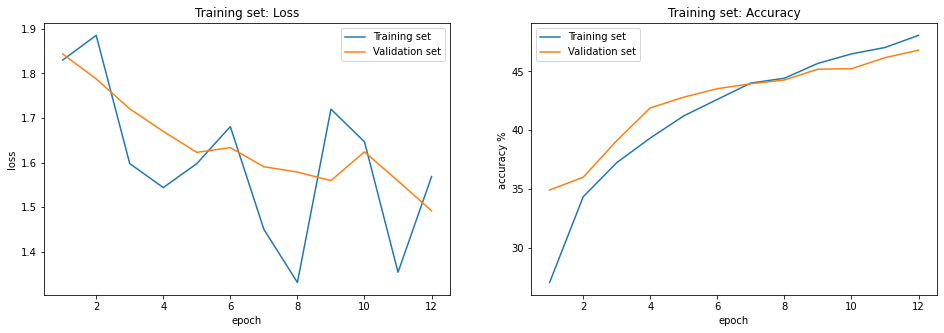

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.94 s Accuracy: 46.54

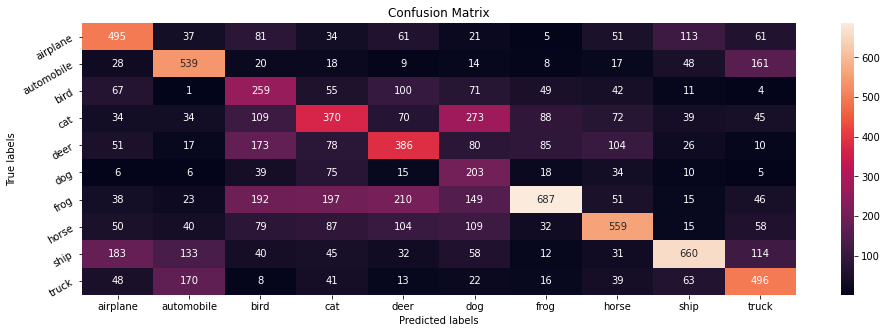

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## P = 0.3

In [0]:
model = NeuralNetwork(dropout=0.3)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.0966179370880127 accuracy: 14.89 %
epoch 0 batch 200------loss: 2.0310354232788086 accuracy: 16.63 %
epoch 0 batch 300------loss: 2.0387582778930664 accuracy: 18.56 %
epoch 0 batch 400------loss: 1.945102572441101 accuracy: 20.308 %
epoch 1 batch 100------loss: 1.9733521938323975 accuracy: 27.54 %
epoch 1 batch 200------loss: 1.8576993942260742 accuracy: 28.045 %
epoch 1 batch 300------loss: 1.9161595106124878 accuracy: 28.277 %
epoch 1 batch 400------loss: 1.840928554534912 accuracy: 28.708 %
epoch 2 batch 100------loss: 1.906165361404419 accuracy: 31.55 %
epoch 2 batch 200------loss: 1.876759648323059 accuracy: 31.63 %
epoch 2 batch 300------loss: 1.792988896369934 accuracy: 31.55 %
epoch 2 batch 400------loss: 1.7290934324264526 accuracy: 31.67 %
epoch 3 batch 100------loss: 1.8851027488708496 accuracy: 32.07 %
epoch 3 batch 200------loss: 1.9034980535507202 accuracy: 31.85 %
epoch 3 batch 300------loss: 1.9443646669387817 accuracy: 32.25 %
epoch 3 batch 400------loss: 1.8613440990447998 accuracy: 32.28 %
epoch 4 batch 100------loss: 1.8321751356124878 accuracy: 32.24 %
epoch 4 batch 200------loss: 1.7621105909347534 accuracy: 32.22 %
epoch 4 batch 300------loss: 1.9289870262145996 accuracy: 32.607 %
epoch 4 batch 400------loss: 1.8641167879104614 accuracy: 33.117 %
epoch 5 batch 100------loss: 1.7622921466827393 accuracy: 34.12 %
epoch 5 batch 200------loss: 1.6248191595077515 accuracy: 34.15 %
epoch 5 batch 300------loss: 1.725953221321106 accuracy: 34.277 %
epoch 5 batch 400------loss: 1.7561572790145874 accuracy: 34.503 %
epoch 6 batch 100------loss: 1.8017692565917969 accuracy: 35.27 %
epoch 6 batch 200------loss: 1.7804371118545532 accuracy: 35.305 %
epoch 6 batch 300------loss: 1.6725672483444214 accuracy: 35.557 %
epoch 6 batch 400------loss: 1.797698974609375 accuracy: 35.597 %
epoch 7 batch 100------loss: 1.7678297758102417 accuracy: 35.85 %
epoch 7 batch 200------loss: 1.7432606220245361 accuracy: 36.06 %
epoch 7 batch 300------loss: 1.8143360614776611 accuracy: 36.047 %
epoch 7 batch 400------loss: 1.8538397550582886 accuracy: 36.023 %
epoch 8 batch 100------loss: 1.8121347427368164 accuracy: 36.75 %
epoch 8 batch 200------loss: 1.6957485675811768 accuracy: 36.555 %
epoch 8 batch 300------loss: 1.6576776504516602 accuracy: 37.047 %
epoch 8 batch 400------loss: 1.7197593450546265 accuracy: 36.888 %
epoch 9 batch 100------loss: 1.752126932144165 accuracy: 37.52 %
epoch 9 batch 200------loss: 1.6321278810501099 accuracy: 37.74 %
epoch 9 batch 300------loss: 1.7336519956588745 accuracy: 37.757 %
epoch 9 batch 400------loss: 1.7939459085464478 accuracy: 37.51 %
epoch 10 batch 100------loss: 1.5804753303527832 accuracy: 37.83 %
epoch 10 batch 200------loss: 1.8252770900726318 accuracy: 38.205 %
epoch 10 batch 300------loss: 1.5103415250778198 accuracy: 37.763 %
epoch 10 batch 400------loss: 1.7338731288909912 accuracy: 37.73 %
epoch 11 batch 100------loss: 1.526706576347351 accuracy: 37.5 %
epoch 11 batch 200------loss: 1.7395892143249512 accuracy: 37.66 %
epoch 11 batch 300------loss: 1.7002416849136353 accuracy: 37.927 %
epoch 11 batch 400------loss: 1.6889315843582153 accuracy: 37.833 %
total time elapsed: 220.73 s

Time elapsed for training: 3.679 min, Accuracy: 37.92 %

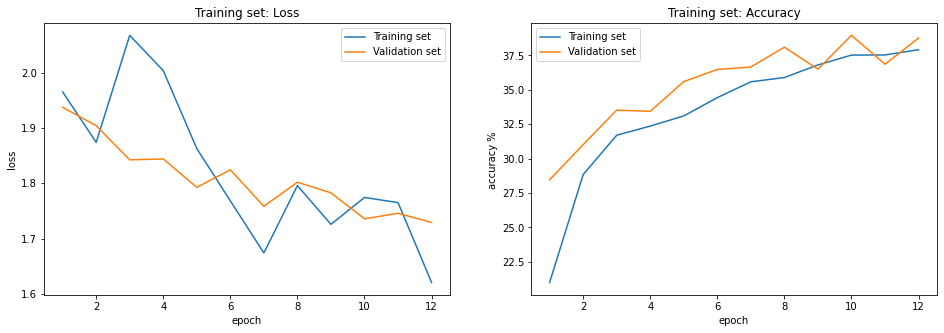

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.28 s Accuracy: 38.54

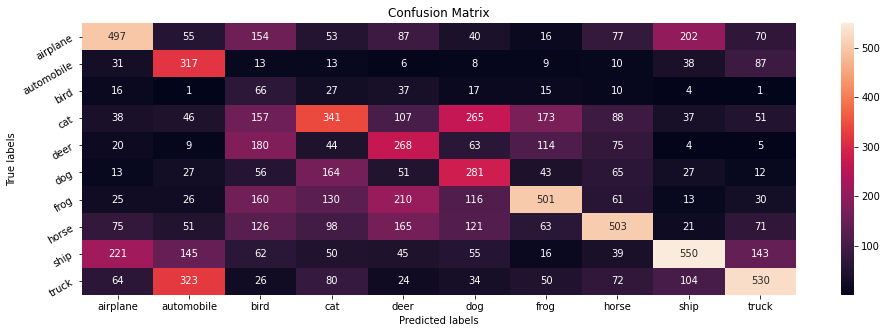

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## P = 0.05

#### SGD

##### lr =0.1

In [0]:
model = NeuralNetwork(dropout=0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.2822816371917725 accuracy: 10.72 %
epoch 0 batch 200------loss: 2.1513566970825195 accuracy: 13.6 %
epoch 0 batch 300------loss: 2.0749404430389404 accuracy: 16.057 %
epoch 0 batch 400------loss: 2.037243604660034 accuracy: 17.942 %
epoch 1 batch 100------loss: 1.9846429824829102 accuracy: 27.79 %
epoch 1 batch 200------loss: 1.894424319267273 accuracy: 28.8 %
epoch 1 batch 300------loss: 1.8341201543807983 accuracy: 29.87 %
epoch 1 batch 400------loss: 1.9110604524612427 accuracy: 30.417 %
epoch 2 batch 100------loss: 1.7345813512802124 accuracy: 33.59 %
epoch 2 batch 200------loss: 1.890244960784912 accuracy: 34.1 %
epoch 2 batch 300------loss: 1.9077638387680054 accuracy: 34.557 %
epoch 2 batch 400------loss: 1.788864016532898 accuracy: 34.885 %
epoch 3 batch 100------loss: 1.8170677423477173 accuracy: 36.12 %
epoch 3 batch 200------loss: 1.677718162536621 accuracy: 36.77 %
epoch 3 batch 300------loss: 1.5853657722473145 accuracy: 37.073 %
epoch 3 batch 400------loss: 1.7318406105041504 accuracy: 37.51 %
epoch 4 batch 100------loss: 1.7465709447860718 accuracy: 39.15 %
epoch 4 batch 200------loss: 1.7637672424316406 accuracy: 39.14 %
epoch 4 batch 300------loss: 1.8537577390670776 accuracy: 39.7 %
epoch 4 batch 400------loss: 1.5137124061584473 accuracy: 40.072 %
epoch 5 batch 100------loss: 1.4706851243972778 accuracy: 40.67 %
epoch 5 batch 200------loss: 1.6880987882614136 accuracy: 40.995 %
epoch 5 batch 300------loss: 1.5938918590545654 accuracy: 40.983 %
epoch 5 batch 400------loss: 1.7071141004562378 accuracy: 41.34 %
epoch 6 batch 100------loss: 1.7175469398498535 accuracy: 43.12 %
epoch 6 batch 200------loss: 1.7998013496398926 accuracy: 42.86 %
epoch 6 batch 300------loss: 1.8288601636886597 accuracy: 42.787 %
epoch 6 batch 400------loss: 1.4963500499725342 accuracy: 42.805 %
epoch 7 batch 100------loss: 1.4686557054519653 accuracy: 44.47 %
epoch 7 batch 200------loss: 1.6243873834609985 accuracy: 44.305 %
epoch 7 batch 300------loss: 1.5567823648452759 accuracy: 44.61 %
epoch 7 batch 400------loss: 1.6108311414718628 accuracy: 44.738 %
epoch 8 batch 100------loss: 1.477277398109436 accuracy: 44.72 %
epoch 8 batch 200------loss: 1.6746004819869995 accuracy: 45.7 %
epoch 8 batch 300------loss: 1.5863182544708252 accuracy: 45.66 %
epoch 8 batch 400------loss: 1.509222388267517 accuracy: 45.733 %
epoch 9 batch 100------loss: 1.600862741470337 accuracy: 47.97 %
epoch 9 batch 200------loss: 1.4826819896697998 accuracy: 47.99 %
epoch 9 batch 300------loss: 1.5039974451065063 accuracy: 47.3 %
epoch 9 batch 400------loss: 1.4739811420440674 accuracy: 47.045 %
epoch 10 batch 100------loss: 1.8016533851623535 accuracy: 47.03 %
epoch 10 batch 200------loss: 1.4307423830032349 accuracy: 47.61 %
epoch 10 batch 300------loss: 1.309442162513733 accuracy: 48.013 %
epoch 10 batch 400------loss: 1.629306435585022 accuracy: 48.002 %
epoch 11 batch 100------loss: 1.5565991401672363 accuracy: 48.81 %
epoch 11 batch 200------loss: 1.6015772819519043 accuracy: 48.915 %
epoch 11 batch 300------loss: 1.4333900213241577 accuracy: 48.923 %
epoch 11 batch 400------loss: 1.355920433998108 accuracy: 48.98 %
total time elapsed: 147.06 s

Time elapsed for training: 2.451 min, Accuracy: 48.9 %
Test set: 
Time elapsed: 1.53 s Accuracy: 42.26

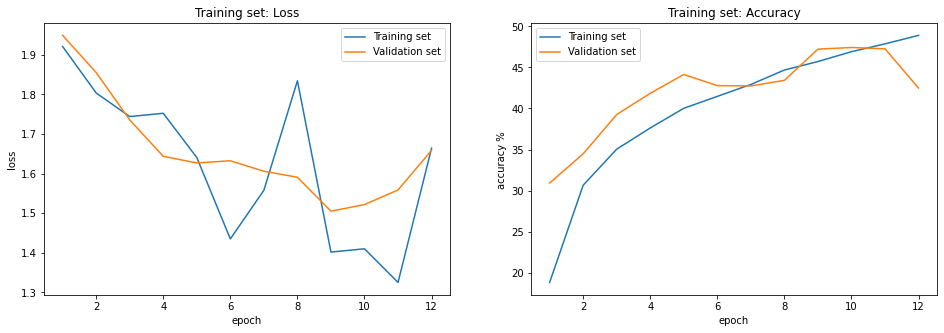

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)


##### lr =0.05

In [0]:
model = NeuralNetwork(dropout=0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.295802593231201 accuracy: 12.67 %
epoch 0 batch 200------loss: 2.2410025596618652 accuracy: 14.28 %
epoch 0 batch 300------loss: 2.0503809452056885 accuracy: 15.477 %
epoch 0 batch 400------loss: 2.107107639312744 accuracy: 16.317 %
epoch 1 batch 100------loss: 2.0207831859588623 accuracy: 23.53 %
epoch 1 batch 200------loss: 1.9404014348983765 accuracy: 24.65 %
epoch 1 batch 300------loss: 1.97528076171875 accuracy: 26.007 %
epoch 1 batch 400------loss: 1.9680323600769043 accuracy: 26.695 %
epoch 2 batch 100------loss: 1.8229789733886719 accuracy: 30.89 %
epoch 2 batch 200------loss: 1.8460421562194824 accuracy: 31.53 %
epoch 2 batch 300------loss: 1.8682583570480347 accuracy: 31.777 %
epoch 2 batch 400------loss: 1.8762288093566895 accuracy: 32.127 %
epoch 3 batch 100------loss: 1.8044028282165527 accuracy: 34.36 %
epoch 3 batch 200------loss: 1.7622867822647095 accuracy: 34.845 %
epoch 3 batch 300------loss: 1.6017498970031738 accuracy: 35.263 %
epoch 3 batch 400------loss: 1.7884397506713867 accuracy: 35.148 %
epoch 4 batch 100------loss: 1.668123483657837 accuracy: 37.77 %
epoch 4 batch 200------loss: 1.6953142881393433 accuracy: 37.32 %
epoch 4 batch 300------loss: 1.6773993968963623 accuracy: 37.53 %
epoch 4 batch 400------loss: 1.6091015338897705 accuracy: 37.752 %
epoch 5 batch 100------loss: 1.8190895318984985 accuracy: 39.86 %
epoch 5 batch 200------loss: 1.5690240859985352 accuracy: 39.96 %
epoch 5 batch 300------loss: 1.5961167812347412 accuracy: 39.873 %
epoch 5 batch 400------loss: 1.7076711654663086 accuracy: 39.86 %
epoch 6 batch 100------loss: 1.662514328956604 accuracy: 40.59 %
epoch 6 batch 200------loss: 1.5477304458618164 accuracy: 41.275 %
epoch 6 batch 300------loss: 1.5050294399261475 accuracy: 41.08 %
epoch 6 batch 400------loss: 1.6807551383972168 accuracy: 41.432 %
epoch 7 batch 100------loss: 1.442054033279419 accuracy: 42.45 %
epoch 7 batch 200------loss: 1.5563991069793701 accuracy: 42.785 %
epoch 7 batch 300------loss: 1.689017653465271 accuracy: 42.833 %
epoch 7 batch 400------loss: 1.5916242599487305 accuracy: 42.833 %
epoch 8 batch 100------loss: 1.521701693534851 accuracy: 43.77 %
epoch 8 batch 200------loss: 1.4664638042449951 accuracy: 43.84 %
epoch 8 batch 300------loss: 1.6394888162612915 accuracy: 44.18 %
epoch 8 batch 400------loss: 1.4900338649749756 accuracy: 44.27 %
epoch 9 batch 100------loss: 1.7779887914657593 accuracy: 44.44 %
epoch 9 batch 200------loss: 1.445314645767212 accuracy: 45.085 %
epoch 9 batch 300------loss: 1.701077938079834 accuracy: 45.1 %
epoch 9 batch 400------loss: 1.4396580457687378 accuracy: 45.282 %
epoch 10 batch 100------loss: 1.4819297790527344 accuracy: 45.54 %
epoch 10 batch 200------loss: 1.3001677989959717 accuracy: 46.17 %
epoch 10 batch 300------loss: 1.5016018152236938 accuracy: 46.33 %
epoch 10 batch 400------loss: 1.448136568069458 accuracy: 46.487 %
epoch 11 batch 100------loss: 1.3967138528823853 accuracy: 48.1 %
epoch 11 batch 200------loss: 1.6501812934875488 accuracy: 47.7 %
epoch 11 batch 300------loss: 1.3335849046707153 accuracy: 47.413 %
epoch 11 batch 400------loss: 1.624341607093811 accuracy: 47.465 %
total time elapsed: 123.95 s

Time elapsed for training: 2.066 min, Accuracy: 47.42 %
Test set: 
Time elapsed: 1.66 s Accuracy: 45.59

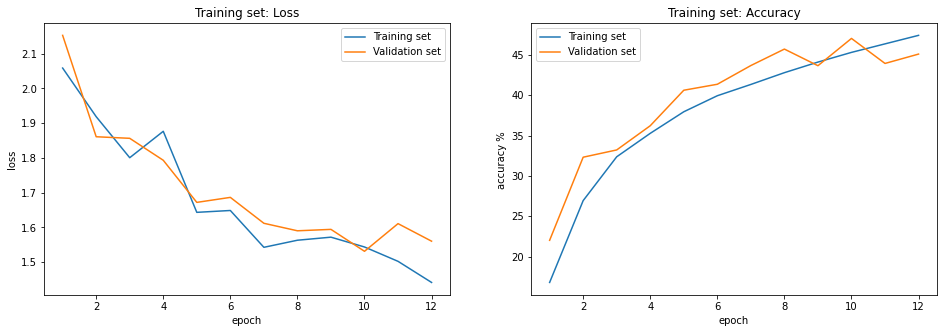

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)


#### Adam

In [0]:
model = NeuralNetwork(dropout=0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 12, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = False)


epoch 0 batch 100------loss: 2.063751459121704 accuracy: 18.48 %
epoch 0 batch 200------loss: 1.9008164405822754 accuracy: 22.915 %
epoch 0 batch 300------loss: 1.9157263040542603 accuracy: 24.843 %
epoch 0 batch 400------loss: 1.9606252908706665 accuracy: 26.652 %
epoch 1 batch 100------loss: 1.8909709453582764 accuracy: 34.22 %
epoch 1 batch 200------loss: 1.7686024904251099 accuracy: 34.63 %
epoch 1 batch 300------loss: 1.7780953645706177 accuracy: 35.0 %
epoch 1 batch 400------loss: 1.803330898284912 accuracy: 35.017 %
epoch 2 batch 100------loss: 1.6599540710449219 accuracy: 38.49 %
epoch 2 batch 200------loss: 1.5851051807403564 accuracy: 38.21 %
epoch 2 batch 300------loss: 1.8166989088058472 accuracy: 38.447 %
epoch 2 batch 400------loss: 1.6424126625061035 accuracy: 38.7 %
epoch 3 batch 100------loss: 1.5879513025283813 accuracy: 40.61 %
epoch 3 batch 200------loss: 1.7229368686676025 accuracy: 40.68 %
epoch 3 batch 300------loss: 1.6601115465164185 accuracy: 40.79 %
epoch 3 batch 400------loss: 1.7062370777130127 accuracy: 40.805 %
epoch 4 batch 100------loss: 1.553006887435913 accuracy: 44.0 %
epoch 4 batch 200------loss: 1.6009364128112793 accuracy: 43.75 %
epoch 4 batch 300------loss: 1.398221492767334 accuracy: 43.533 %
epoch 4 batch 400------loss: 1.5837773084640503 accuracy: 43.383 %
epoch 5 batch 100------loss: 1.5756498575210571 accuracy: 44.36 %
epoch 5 batch 200------loss: 1.5403530597686768 accuracy: 44.275 %
epoch 5 batch 300------loss: 1.5221089124679565 accuracy: 44.567 %
epoch 5 batch 400------loss: 1.7409487962722778 accuracy: 44.583 %
epoch 6 batch 100------loss: 1.5833145380020142 accuracy: 44.59 %
epoch 6 batch 200------loss: 1.3866806030273438 accuracy: 44.985 %
epoch 6 batch 300------loss: 1.5974857807159424 accuracy: 45.483 %
epoch 6 batch 400------loss: 1.399757981300354 accuracy: 45.543 %
epoch 7 batch 100------loss: 1.4756343364715576 accuracy: 46.14 %
epoch 7 batch 200------loss: 1.3647091388702393 accuracy: 46.395 %
epoch 7 batch 300------loss: 1.4192795753479004 accuracy: 46.227 %
epoch 7 batch 400------loss: 1.3528861999511719 accuracy: 46.485 %
epoch 8 batch 100------loss: 1.319633960723877 accuracy: 46.89 %
epoch 8 batch 200------loss: 1.700616478919983 accuracy: 47.235 %
epoch 8 batch 300------loss: 1.465134859085083 accuracy: 47.27 %
epoch 8 batch 400------loss: 1.3971023559570312 accuracy: 47.288 %
epoch 9 batch 100------loss: 1.529105544090271 accuracy: 48.91 %
epoch 9 batch 200------loss: 1.2941361665725708 accuracy: 48.865 %
epoch 9 batch 300------loss: 1.573792576789856 accuracy: 48.847 %
epoch 9 batch 400------loss: 1.4858176708221436 accuracy: 48.888 %
epoch 10 batch 100------loss: 1.4110058546066284 accuracy: 50.05 %
epoch 10 batch 200------loss: 1.3907321691513062 accuracy: 49.825 %
epoch 10 batch 300------loss: 1.4102243185043335 accuracy: 49.753 %
epoch 10 batch 400------loss: 1.4424902200698853 accuracy: 49.738 %
epoch 11 batch 100------loss: 1.371744990348816 accuracy: 50.81 %
epoch 11 batch 200------loss: 1.4057594537734985 accuracy: 50.08 %
epoch 11 batch 300------loss: 1.3125507831573486 accuracy: 50.083 %
epoch 11 batch 400------loss: 1.3006868362426758 accuracy: 49.957 %
total time elapsed: 214.77 s

Time elapsed for training: 3.579 min, Accuracy: 49.85 %

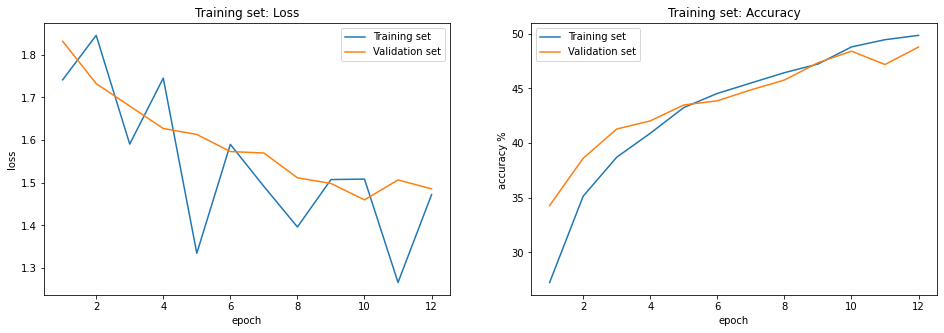

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)


Test set: 
Time elapsed: 1.28 s Accuracy: 48.93

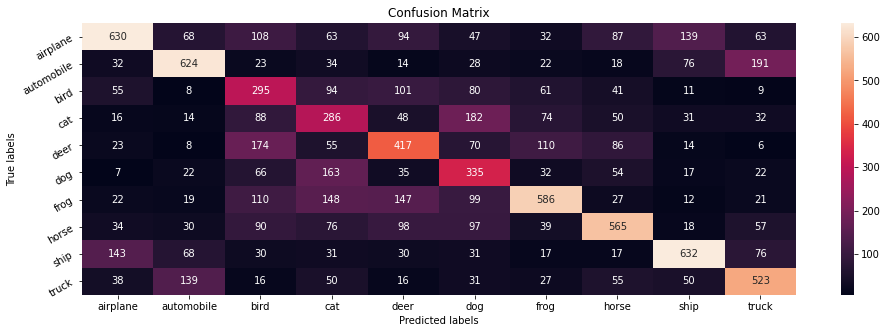

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = False)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

# Convolution Layers

## 2 conv layers

In [0]:
#Define network architecture
class CNN(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2)
          # 16 / 2 = 8        
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(24*8*8, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 3, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)


epoch 0 batch 100------loss: 1.9553968906402588 accuracy: 18.16 %
epoch 0 batch 200------loss: 1.4710198640823364 accuracy: 26.92 %
epoch 0 batch 300------loss: 1.3709641695022583 accuracy: 32.603 %
epoch 0 batch 400------loss: 1.4512711763381958 accuracy: 36.385 %
epoch 1 batch 100------loss: 1.2699803113937378 accuracy: 54.65 %
epoch 1 batch 200------loss: 1.2877877950668335 accuracy: 55.255 %
epoch 1 batch 300------loss: 1.091099739074707 accuracy: 56.28 %
epoch 1 batch 400------loss: 1.2025460004806519 accuracy: 57.133 %
epoch 2 batch 100------loss: 0.8856180310249329 accuracy: 64.51 %
epoch 2 batch 200------loss: 0.8923822641372681 accuracy: 65.26 %
epoch 2 batch 300------loss: 0.9919785857200623 accuracy: 65.87 %
epoch 2 batch 400------loss: 0.829163670539856 accuracy: 65.943 %
total time elapsed: 50.6 s

Time elapsed for training: 0.843 min, Accuracy: 66.03 %

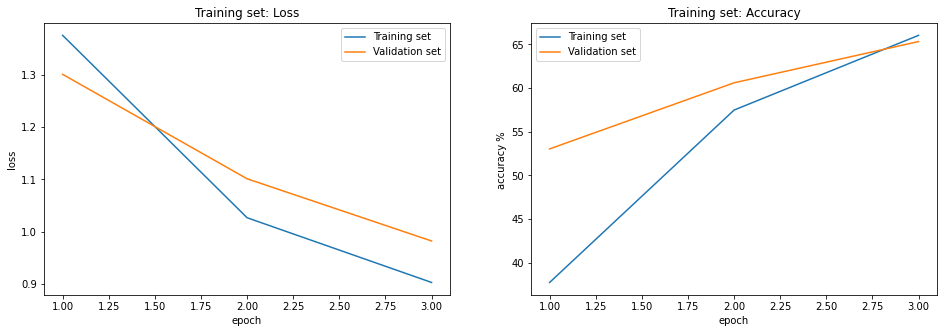

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.65 s Accuracy: 64.97

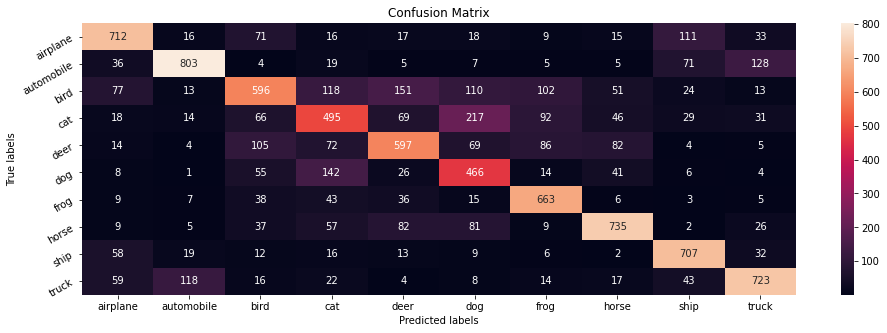

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## 3 conv layers

In [0]:
#Define network architecture
class CNN_3(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 1.8107837438583374 accuracy: 22.99 %
epoch 0 batch 200------loss: 1.4679034948349 accuracy: 30.12 %
epoch 0 batch 300------loss: 1.5550581216812134 accuracy: 34.867 %
epoch 0 batch 400------loss: 1.2993371486663818 accuracy: 38.3 %
epoch 1 batch 100------loss: 1.1850330829620361 accuracy: 55.11 %
epoch 1 batch 200------loss: 1.0782794952392578 accuracy: 56.41 %
epoch 1 batch 300------loss: 1.3855427503585815 accuracy: 56.873 %
epoch 1 batch 400------loss: 1.1494555473327637 accuracy: 57.842 %
epoch 2 batch 100------loss: 0.9983916282653809 accuracy: 66.31 %
epoch 2 batch 200------loss: 0.9570974111557007 accuracy: 66.34 %
epoch 2 batch 300------loss: 0.81822669506073 accuracy: 66.26 %
epoch 2 batch 400------loss: 0.7998526096343994 accuracy: 66.562 %
epoch 3 batch 100------loss: 0.6509251594543457 accuracy: 72.45 %
epoch 3 batch 200------loss: 0.9802894592285156 accuracy: 72.815 %
epoch 3 batch 300------loss: 0.7735105156898499 accuracy: 73.123 %
epoch 3 batch 400------loss: 0.8164359927177429 accuracy: 73.105 %
epoch 4 batch 100------loss: 0.6589239239692688 accuracy: 79.1 %
epoch 4 batch 200------loss: 0.7194024920463562 accuracy: 78.62 %
epoch 4 batch 300------loss: 0.617347240447998 accuracy: 78.673 %
epoch 4 batch 400------loss: 0.492565393447876 accuracy: 78.43 %
total time elapsed: 89.48 s

Time elapsed for training: 1.491 min, Accuracy: 78.29 %

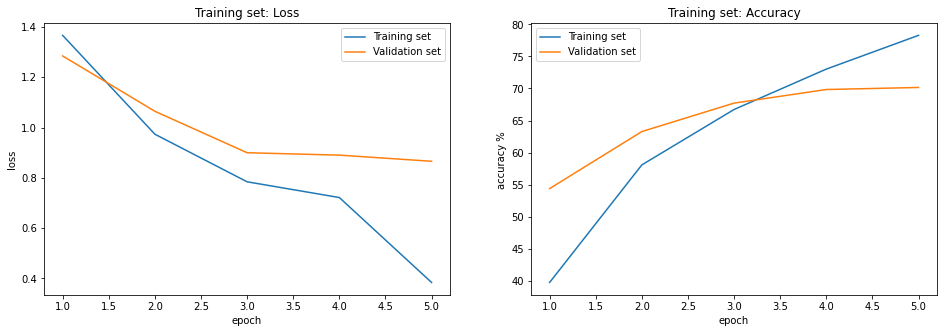

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.78 s Accuracy: 69.41

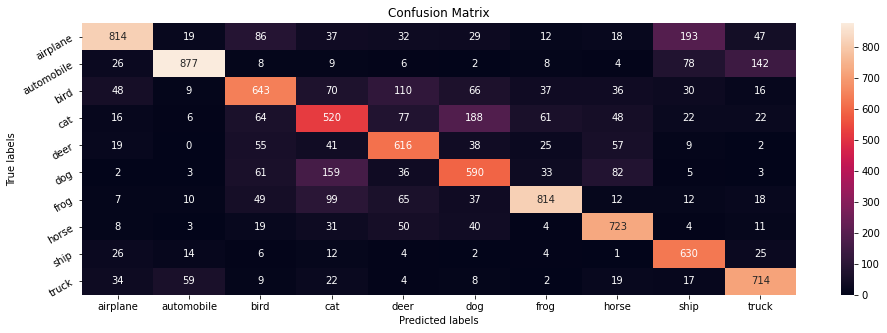

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

train for 4 epochs

In [0]:
model = CNN_3()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 4, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 1.8061506748199463 accuracy: 21.97 %
epoch 0 batch 200------loss: 1.5829919576644897 accuracy: 27.695 %
epoch 0 batch 300------loss: 1.5774766206741333 accuracy: 32.217 %
epoch 0 batch 400------loss: 1.276801586151123 accuracy: 36.107 %
epoch 1 batch 100------loss: 1.307114601135254 accuracy: 54.31 %
epoch 1 batch 200------loss: 1.1861220598220825 accuracy: 54.645 %
epoch 1 batch 300------loss: 1.036321997642517 accuracy: 55.487 %
epoch 1 batch 400------loss: 1.310124158859253 accuracy: 56.447 %
epoch 2 batch 100------loss: 1.0736804008483887 accuracy: 63.29 %
epoch 2 batch 200------loss: 0.9756859540939331 accuracy: 63.835 %
epoch 2 batch 300------loss: 0.7849770188331604 accuracy: 64.16 %
epoch 2 batch 400------loss: 0.9368997812271118 accuracy: 64.578 %
epoch 3 batch 100------loss: 0.869922935962677 accuracy: 70.58 %
epoch 3 batch 200------loss: 0.9243144989013672 accuracy: 70.725 %
epoch 3 batch 300------loss: 0.7177831530570984 accuracy: 70.61 %
epoch 3 batch 400------loss: 0.8065926432609558 accuracy: 70.825 %
total time elapsed: 74.21 s

Time elapsed for training: 1.237 min, Accuracy: 70.76 %

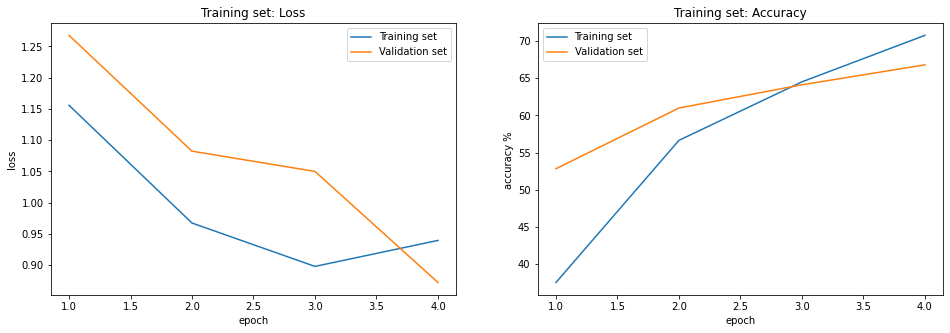

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.81 s Accuracy: 66.36

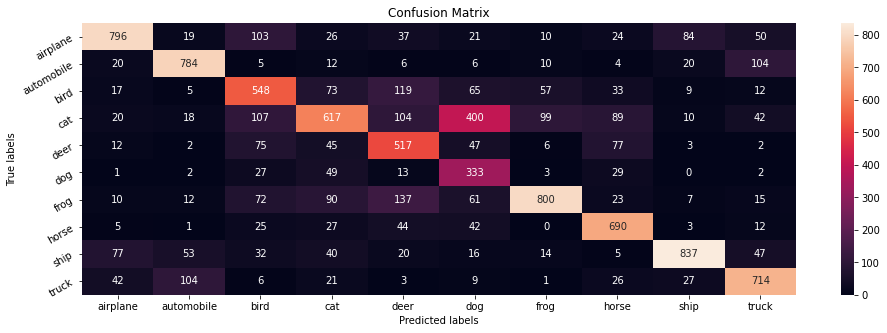

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### use SGD

In [0]:
model = CNN_3()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 2.3087265491485596 accuracy: 9.73 %
epoch 0 batch 200------loss: 2.299591541290283 accuracy: 9.915 %
epoch 0 batch 300------loss: 2.3081161975860596 accuracy: 10.06 %
epoch 0 batch 400------loss: 2.3012285232543945 accuracy: 10.107 %
epoch 1 batch 100------loss: 2.303626775741577 accuracy: 11.27 %
epoch 1 batch 200------loss: 2.301579236984253 accuracy: 11.22 %
epoch 1 batch 300------loss: 2.3050012588500977 accuracy: 11.593 %
epoch 1 batch 400------loss: 2.300443172454834 accuracy: 12.11 %
epoch 2 batch 100------loss: 2.2979848384857178 accuracy: 12.3 %
epoch 2 batch 200------loss: 2.296909809112549 accuracy: 11.6 %
epoch 2 batch 300------loss: 2.2725348472595215 accuracy: 12.717 %
epoch 2 batch 400------loss: 2.201256513595581 accuracy: 13.648 %
epoch 3 batch 100------loss: 2.2349345684051514 accuracy: 17.25 %
epoch 3 batch 200------loss: 1.980147361755371 accuracy: 18.38 %
epoch 3 batch 300------loss: 2.1129355430603027 accuracy: 19.553 %
epoch 3 batch 400------loss: 2.034853219985962 accuracy: 21.005 %
epoch 4 batch 100------loss: 1.8656855821609497 accuracy: 30.04 %
epoch 4 batch 200------loss: 1.9105479717254639 accuracy: 31.45 %
epoch 4 batch 300------loss: 1.8875597715377808 accuracy: 32.43 %
epoch 4 batch 400------loss: 1.6669247150421143 accuracy: 33.215 %
total time elapsed: 76.41 s

Time elapsed for training: 1.274 min, Accuracy: 33.71 %

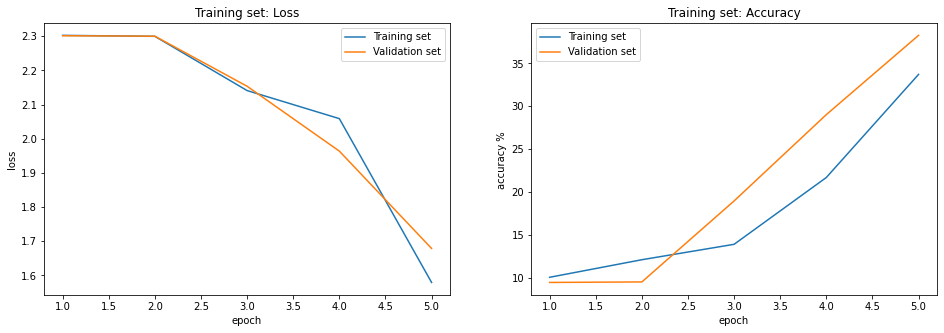

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.78 s Accuracy: 37.48

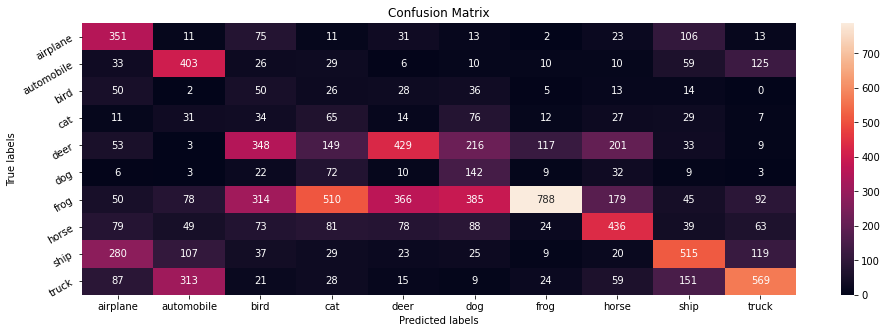

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### add RELU after pooling

In [0]:
#Define network architecture
class CNN_3R(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          nn.ReLU(),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3R()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 2.0178592205047607 accuracy: 15.7 %
epoch 0 batch 200------loss: 1.7877373695373535 accuracy: 19.565 %
epoch 0 batch 300------loss: 1.6678889989852905 accuracy: 23.17 %
epoch 0 batch 400------loss: 1.5272446870803833 accuracy: 26.512 %
epoch 1 batch 100------loss: 1.379574179649353 accuracy: 42.08 %
epoch 1 batch 200------loss: 1.496138334274292 accuracy: 43.455 %
epoch 1 batch 300------loss: 1.2600122690200806 accuracy: 45.267 %
epoch 1 batch 400------loss: 1.3687266111373901 accuracy: 46.582 %
epoch 2 batch 100------loss: 1.1930646896362305 accuracy: 52.49 %
epoch 2 batch 200------loss: 1.1152106523513794 accuracy: 53.905 %
epoch 2 batch 300------loss: 1.2066104412078857 accuracy: 54.493 %
epoch 2 batch 400------loss: 1.2221031188964844 accuracy: 55.178 %
epoch 3 batch 100------loss: 0.8682798743247986 accuracy: 59.56 %
epoch 3 batch 200------loss: 1.1219735145568848 accuracy: 59.94 %
epoch 3 batch 300------loss: 1.028945803642273 accuracy: 60.597 %
epoch 3 batch 400------loss: 1.1591452360153198 accuracy: 60.957 %
epoch 4 batch 100------loss: 1.0851449966430664 accuracy: 64.85 %
epoch 4 batch 200------loss: 1.0187662839889526 accuracy: 65.1 %
epoch 4 batch 300------loss: 0.848655641078949 accuracy: 65.39 %
epoch 4 batch 400------loss: 0.9529368877410889 accuracy: 65.233 %
total time elapsed: 96.58 s

Time elapsed for training: 1.61 min, Accuracy: 65.09 %

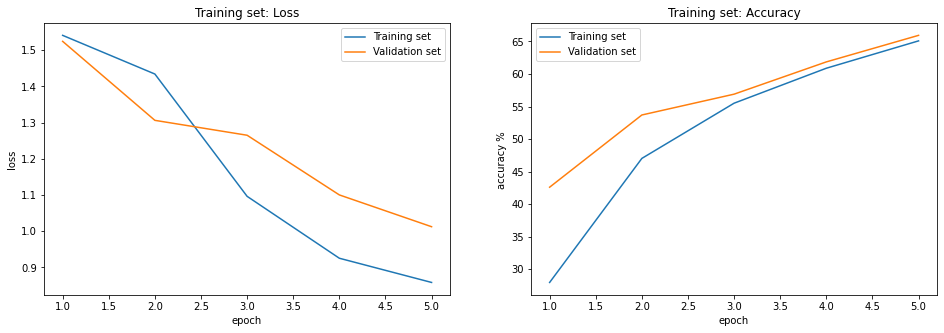

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.79 s Accuracy: 65.01

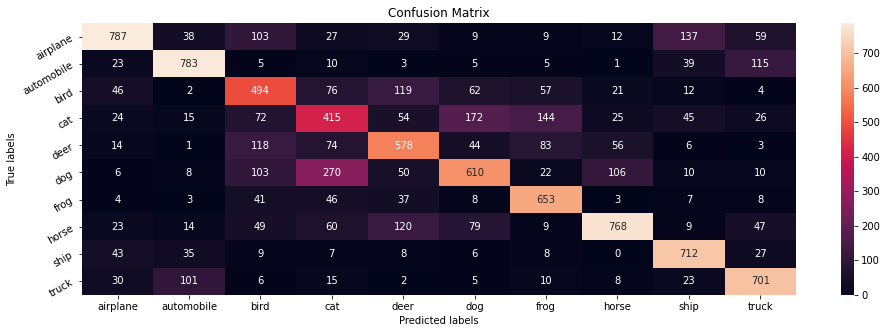

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### add dropout = 0.1

In [0]:
#Define network architecture
class CNN_3_drop(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Dropout2d(p=dropout),
          
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Dropout2d(p=dropout),
          
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4 
          nn.Dropout2d(p=dropout)
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3_drop(dropout= 0.05)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 1.8314982652664185 accuracy: 19.24 %
epoch 0 batch 200------loss: 1.608543872833252 accuracy: 25.495 %
epoch 0 batch 300------loss: 1.503685474395752 accuracy: 29.87 %
epoch 0 batch 400------loss: 1.4878276586532593 accuracy: 33.532 %
epoch 1 batch 100------loss: 1.2914739847183228 accuracy: 50.88 %
epoch 1 batch 200------loss: 1.0928443670272827 accuracy: 52.09 %
epoch 1 batch 300------loss: 1.2318207025527954 accuracy: 53.03 %
epoch 1 batch 400------loss: 1.3203036785125732 accuracy: 53.805 %
epoch 2 batch 100------loss: 1.3178155422210693 accuracy: 60.1 %
epoch 2 batch 200------loss: 0.9348536133766174 accuracy: 60.65 %
epoch 2 batch 300------loss: 1.1043295860290527 accuracy: 61.507 %
epoch 2 batch 400------loss: 1.141910433769226 accuracy: 61.847 %
epoch 3 batch 100------loss: 0.8859401941299438 accuracy: 66.84 %
epoch 3 batch 200------loss: 0.9550565481185913 accuracy: 66.99 %
epoch 3 batch 300------loss: 0.933905839920044 accuracy: 67.15 %
epoch 3 batch 400------loss: 0.7773552536964417 accuracy: 67.285 %
epoch 4 batch 100------loss: 0.6777986884117126 accuracy: 71.83 %
epoch 4 batch 200------loss: 0.7233237624168396 accuracy: 71.895 %
epoch 4 batch 300------loss: 0.7000409960746765 accuracy: 71.967 %
epoch 4 batch 400------loss: 0.7852117419242859 accuracy: 71.835 %
total time elapsed: 90.5 s

Time elapsed for training: 1.508 min, Accuracy: 71.7 %

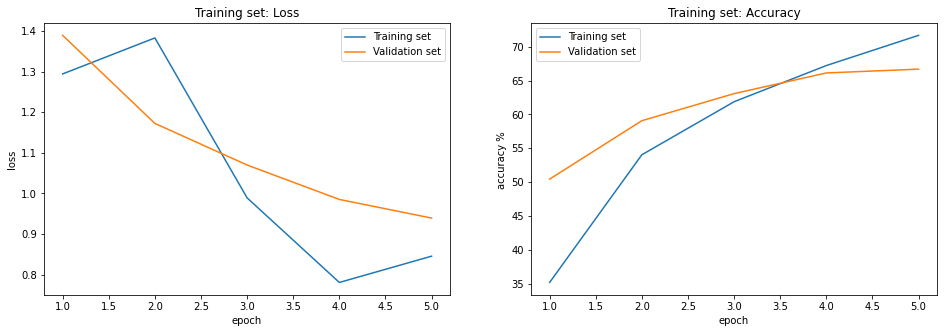

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.92 s Accuracy: 66.23

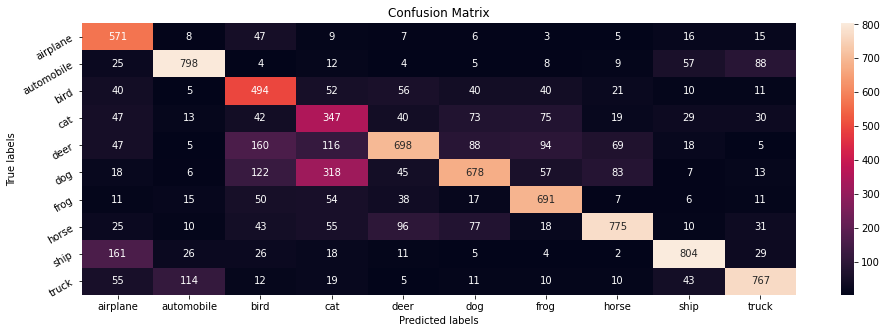

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

### kernel size

In [0]:
#Define network architecture
class CNN_3k(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 5, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - )/1 + 1 = 30
          nn.MaxPool2d(kernel_size=3),
          # 30 / 3 = 10
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, padding=1, stride=1),
          #output layer = (10 + 2*1 - 5)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=4),
          # 8 / 4 = 2  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (2 + 2*1 - 3)/1 + 1 = 2
          nn.MaxPool2d(kernel_size=2),
          # 2 / 2 = 1  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(64*1*1, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_3k()

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 1.9203925132751465 accuracy: 17.8 %
epoch 0 batch 200------loss: 1.7866413593292236 accuracy: 22.37 %
epoch 0 batch 300------loss: 1.6482207775115967 accuracy: 25.957 %
epoch 0 batch 400------loss: 1.5354046821594238 accuracy: 28.708 %
epoch 1 batch 100------loss: 1.4036338329315186 accuracy: 43.02 %
epoch 1 batch 200------loss: 1.468916654586792 accuracy: 44.27 %
epoch 1 batch 300------loss: 1.2910094261169434 accuracy: 45.217 %
epoch 1 batch 400------loss: 1.3155465126037598 accuracy: 46.08 %
epoch 2 batch 100------loss: 1.2269339561462402 accuracy: 52.33 %
epoch 2 batch 200------loss: 1.2195844650268555 accuracy: 52.57 %
epoch 2 batch 300------loss: 1.2100852727890015 accuracy: 53.33 %
epoch 2 batch 400------loss: 1.3455771207809448 accuracy: 53.792 %
epoch 3 batch 100------loss: 1.1845009326934814 accuracy: 57.7 %
epoch 3 batch 200------loss: 1.06291925907135 accuracy: 57.965 %
epoch 3 batch 300------loss: 1.0953688621520996 accuracy: 57.813 %
epoch 3 batch 400------loss: 1.131338119506836 accuracy: 58.047 %
epoch 4 batch 100------loss: 0.9924483299255371 accuracy: 60.8 %
epoch 4 batch 200------loss: 1.091858148574829 accuracy: 60.6 %
epoch 4 batch 300------loss: 1.071813702583313 accuracy: 60.77 %
epoch 4 batch 400------loss: 1.1668683290481567 accuracy: 60.64 %
total time elapsed: 63.14 s

Time elapsed for training: 1.052 min, Accuracy: 60.54 %

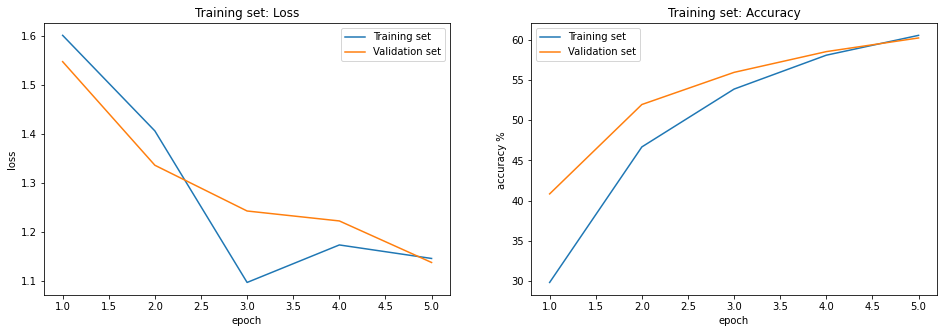

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 1.55 s Accuracy: 60.35

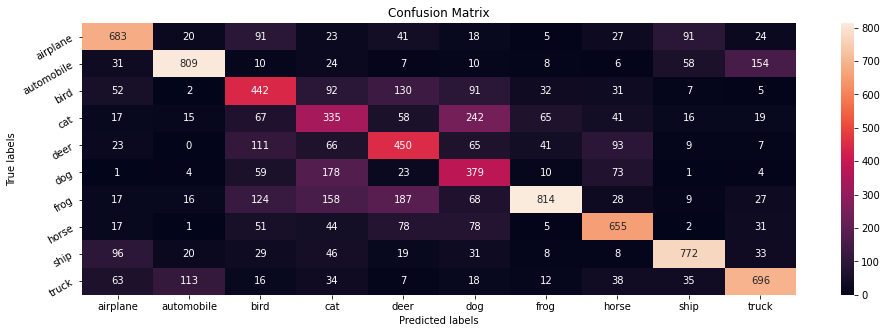

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)

## 4 conv layers

In [0]:
#Define network architecture
class CNN_4(nn.Module):

    def __init__(self, dropout = 0, input_size=INPUT_SIZE, output_size=NUM_CLASSES):
        super().__init__()
        self.convolution_layers = nn.Sequential(
          # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
          nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
          #output layer = (32 + 2*1 - 3)/1 + 1 = 32
          nn.MaxPool2d(kernel_size=2),
          # 32 / 2 = 16
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
          #output layer = (16 + 2*1 - 3)/1 + 1 = 16
          nn.MaxPool2d(kernel_size=2),
          # 16 / 2 = 8  
          nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, padding=1, stride=1),
          #output layer = (8 + 2*1 - 3)/1 + 1 = 8
          nn.MaxPool2d(kernel_size=2),
          # 8 / 2 = 4  
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
          #output layer = (4 + 2*1 - 3)/1 + 1 = 4
          nn.MaxPool2d(kernel_size=2),
          # 4 / 2 = 2  
        )
        
        self.linear_layers = nn.Sequential(
        nn.Linear(128*2*2, 1024),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(64, output_size) 
        )

    def forward(self, X):
        X = self.convolution_layers(X)
        #flatten data 
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        return  X 

In [0]:
model = CNN_4(dropout=0)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train model 
model, train_metrics, time_elapsed = train_NN(model = model, num_epochs = 5, optimizer_fxn = optimizer, loss_fxn = loss, isCNN = True)

epoch 0 batch 100------loss: 1.7402501106262207 accuracy: 20.64 %
epoch 0 batch 200------loss: 1.6070663928985596 accuracy: 25.855 %
epoch 0 batch 300------loss: 1.6346478462219238 accuracy: 30.333 %
epoch 0 batch 400------loss: 1.5508953332901 accuracy: 33.24 %
epoch 1 batch 100------loss: 1.3209611177444458 accuracy: 51.08 %
epoch 1 batch 200------loss: 1.3291277885437012 accuracy: 51.765 %
epoch 1 batch 300------loss: 1.2184228897094727 accuracy: 52.93 %
epoch 1 batch 400------loss: 1.2599769830703735 accuracy: 53.83 %
epoch 2 batch 100------loss: 1.2761327028274536 accuracy: 60.92 %
epoch 2 batch 200------loss: 1.1058838367462158 accuracy: 61.93 %
epoch 2 batch 300------loss: 1.0664079189300537 accuracy: 62.403 %
epoch 2 batch 400------loss: 0.9708202481269836 accuracy: 62.892 %
epoch 3 batch 100------loss: 0.9503912925720215 accuracy: 68.16 %
epoch 3 batch 200------loss: 0.6972596049308777 accuracy: 68.655 %
epoch 3 batch 300------loss: 0.8399888873100281 accuracy: 69.033 %
epoch 3 batch 400------loss: 0.9508135318756104 accuracy: 68.765 %
epoch 4 batch 100------loss: 0.6774755120277405 accuracy: 73.95 %
epoch 4 batch 200------loss: 0.9228206872940063 accuracy: 74.085 %
epoch 4 batch 300------loss: 0.6143659949302673 accuracy: 73.963 %
epoch 4 batch 400------loss: 0.7466328144073486 accuracy: 73.977 %
total time elapsed: 109.13 s

Time elapsed for training: 0.035 min, Accuracy: 73.88 %

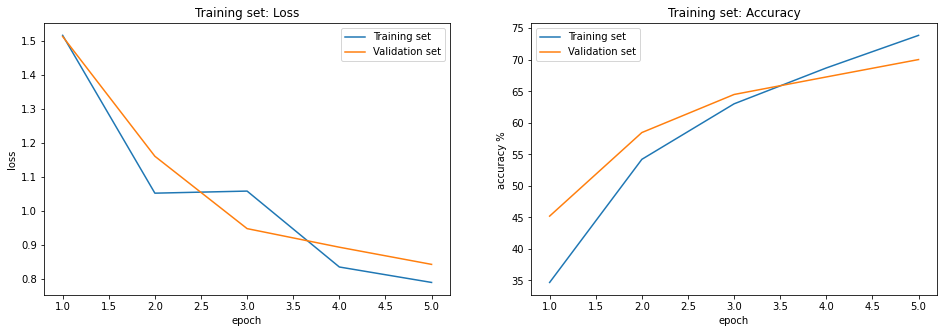

In [0]:
print("Time elapsed for training: ", round(time_elapsed/60, 3) , "min,", "Accuracy: ", round(train_metrics.t_accuracy.values[-1], 2), "%" )
plot_accuracy_loss(train_metrics)

Test set: 
Time elapsed: 2.6 s Accuracy: 68.41

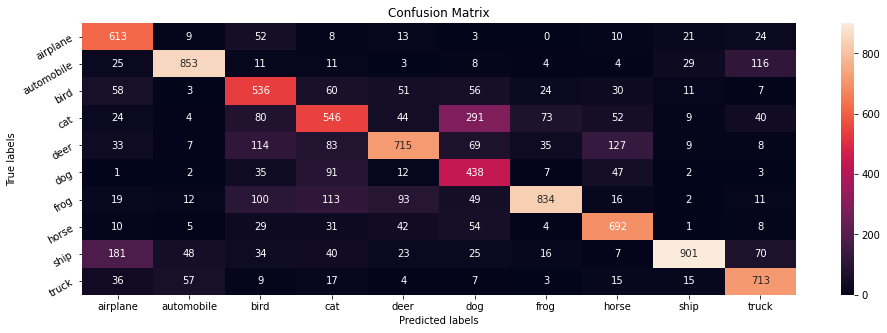

In [0]:
#test model 
time_elapsed, loss, accuracy, y_pred, y_actual = test_NN(model = model, loss_fxn = nn.CrossEntropyLoss(), isCNN = True)
cm = confusion_matrix(y_pred.view(-1),y_actual.view(-1))
plot_confusion_matrix(cm)